


# ParselTongue 101
<img src='img/parseltongue.jpg' align='left'/><br>

"YEAH, HE'S A PARSER-TONGUE."

## Terminology

* **Document** - It is a piece of text to be analyzed. It can be as short as a sentence e.g. tweets, or it can be as long as an encyclopedia. These is no constrain on the length of text.
* **Corpus** - It is a collection of Documents. To make analysis meaningful, a corpus usually consists of document that are similar in length, and comparable to one another.
* **Lexicon** - A collection of words. Think of this has a dictionary minus the definition of words.
* **Taxonomy** - A branch of science that encompasses the description, identification, nomenclature, and classification of organisms. In the context of text, it is the classification of words e.g. words that convery positive sentiment, words that convey negative sentiments.
* **Ontologies** - A set of concepts and categories in a subject area or domain that shows their properties and the relations between them.

## Python Libraries for Text Analytics

In python, some of the libraries commonly used for text analytics are:

* **nltk** (natural language toolkit) - A general purpose text analytics library.
* **pattern** - A general purpose text analytics library.
* **gensim** - mainly used for topic modelling. Topic modelling is the unsupervised categorization of text into "topics"
* **pyLDAvis** - A LDA visualization library. LDA is a method for performing topic modelling
* **wordcloud** - A word visualization library.

In [1]:
# load some python libraries for this demonstration
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from IPython.display import display, HTML

# for text analysis
import gensim
from gensim import corpora, models, similarities
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.sentiment import vader
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from pattern.en import lemma, mood

# for visualizing text analysis result
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud

from matplotlib.cbook import flatten
import matplotlib.pyplot as plt
import os
import pickle
import re
import string
import time
import glob

import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, csr_matrix
# import warnings
warnings.filterwarnings('ignore')

# set options
% matplotlib inline
pyLDAvis.enable_notebook()
pd.set_option('display.max_colwidth', -1)

## Text Analysis Process

Text is an unstructured data. It is not organized in a pre-defined manner, like what we are familiar with in a spreadsheet. The first 3 steps of the text analysis process will involve structuring the texts.

The text analysis process can be broken down into the following:

1. Tokenization - This is the decomposition of documents into individual words. Documents can also be decomposed into sentences, followed by decomposing each sentence into words.
* Preprocessing - This is a series of optional steps to 'clean' the tokens.
    * Lowercase characters
    * Remove stop words
    * Remove punctuations
    * Stemming/lemmatizing
    
    (cont...)

<p>3. Structuring text</p> 

* Sparse matrix representation
* Term weighting

<p>4. Enhancing texts</p>

* Ngram
* Part of speech (POS) tagging
* Entity recognition

<p>5. Performing analysis</p>

* Sentiment analysis
* Document similarity
* Topic modelling
* Topic classification (For exploration)
* Document summarization (For exploration)

In [2]:
doc1 = 'Text is unstructured, thus needs to be structured for analysis.'
doc2 = 'When structured, text can be treated as structured data for analysis.'
corpus1_1 = [doc1, doc2] 
token_list = []
import collections
for doc in corpus1_1:
    temp_dict = collections.defaultdict(int)
    tokens = nltk.word_tokenize(doc)
    for t in tokens:
        temp_dict[t] += 1
    token_list.append(temp_dict)
    
corpus1_1_df = pd.DataFrame(token_list, index=[doc1, doc2])
corpus1_1_df = corpus1_1_df.fillna(0)

## Tokenization

Texts are unstructured data. In order to perform analysis on them, it has to be converted into a structured data similar like the one shown here: 

{{corpus1_1_df}}

**Tokenization** is rule based: split the sentence/document by a certain delimiter/separator e.g. by the punctations between sentences or the space between words. Some other rules can be used in conjunction. 

Introducing 3 tokenizers:

1. nltk.sent_tokenize()
1. nltk.word_tokenize()
* TweetTokenizer()

### *nltk.sent_tokenize*

In [3]:
doc3 = "This is the result of using nltk.sent_tokenize. It's exciting to hear about text analytics today!!! :D:)"
display(nltk.sent_tokenize(doc3))

['This is the result of using nltk.sent_tokenize.',
 "It's exciting to hear about text analytics today!!!",
 ':D:)']

### *nltk.word_tokenize*

In [4]:
doc3 = 'This is the result of using nltk.word_tokenize.'
display(nltk.word_tokenize(doc3))

['This', 'is', 'the', 'result', 'of', 'using', 'nltk.word_tokenize', '.']

Notice that the period at the end of the sentence is tokenized, but the period in the middle of *nltk.word_tokenize* is not.

Can *nltk.word_tokenize* handle emoticons?

In [5]:
doc4 = "It's exciting to hear about text analytics today!!! :D:)"
doc4_tokens = nltk.word_tokenize(doc4)
print doc4_tokens

['It', "'s", 'exciting', 'to', 'hear', 'about', 'text', 'analytics', 'today', '!', '!', '!', ':', 'D', ':', ')']


### _TweetTokenizer()_

In reviews and informal texts, people may include emoticons to express their sentiments. We saw that *nltk.word_tokeniz()* was unable to handle it. Tokenizing on reviews/informal texts may need to consider emoticons if we are going to perform sentiment analysis.

In [6]:
tknz = TweetTokenizer() # From the nltk library. Able to preserve emoticon.

print doc4
print tknz.tokenize(doc4)

It's exciting to hear about text analytics today!!! :D:)
[u"It's", u'exciting', u'to', u'hear', u'about', u'text', u'analytics', u'today', u'!', u'!', u'!', u':D', u':)']


See the difference in how _TweetTokenizer_ and *word_tokenize* tokenizes the emoticon and "It's".
Take note of this and the implications. I'll highlight later.

## Preprocessing

Here are some of the common _(but optional)_ steps performed in pre-processing.

* Lowercasing
* Remove stop words
* Remove punctuations
* Remove tokens matching a certain pattern
* Stemming/Lemmatizing

The purpose of preprocessing is to reduce the number of tokens. I will highlight how each of the pre-processing steps achieve that goal.

### Lowercasing

The first letter of a word at the beginning of a sentence is capitalized, but this word is essentially the same word if it happens in the middle of the sentence. By lowercasing, those words will be considered the same.

When do we not want to lowercase?

* _AIDS_ and _aids_

### Remove stop words

**Stop words** are common words like 'in', 'the', 'that', 'a' etc. that appear in abundance and does not help in differentiating 1 document from another. 

In [7]:
stop_words = stopwords.words('english') # From the nltk library
# show the stop words
print ', '.join(stop_words), '\n'

doc4_stopwords_rm = [w for w in doc4_tokens if w not in stop_words]
print doc4_tokens
print doc4_stopwords_rm

i, me, my, myself, we, our, ours, ourselves, you, your, yours, yourself, yourselves, he, him, his, himself, she, her, hers, herself, it, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, should, now, d, ll, m, o, re, ve, y, ain, aren, couldn, didn, doesn, hadn, hasn, haven, isn, ma, mightn, mustn, needn, shan, shouldn, wasn, weren, won, wouldn 

['It', "'s", 'exciting', 'to', 'hear', 'about', 'text', 'analytics', 'today', '!', '!', '!', ':', 'D', 

Notice that the stopwords are in lowercase, hence the stopwords in the document must be in lowercase before it can be removed.

In addition, one can always customize the stopwords to suit analysis needs.

Recall previously, *nltk.word_tokenize()* tokeenizes "it's" into "it" and "'s", but "'s" is not in the stopword list. We can add "'s", as well as some other common " ' " words, into the stopword list before filtering those words:

In [8]:
additional_sw = ["n't", "'s", "'re", "'m"]
stop_words += additional_sw
print stop_words

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

### Remove punctuations

In [9]:
print 'Punctuations', string.punctuation, '\n' # List of punctuations in the string library

doc4_punc_rm = [w for w in doc4_stopwords_rm if w not in string.punctuation]
print doc4_stopwords_rm
print doc4_punc_rm

Punctuations !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 

['It', "'s", 'exciting', 'hear', 'text', 'analytics', 'today', '!', '!', '!', ':', 'D', ':', ')']
['It', "'s", 'exciting', 'hear', 'text', 'analytics', 'today', 'D']


In [10]:
# A better tokenization that considers emoticons, apostrophes and lowercase.
# Uses regex to search for patterns in words as well.
doc4_better_tokens4 = list(flatten([nltk.word_tokenize(w) if re.search( "|".join(additional_sw)+'$', w) else w 
                 for w in tknz.tokenize(doc4)]))
doc4_better_clean = [w.lower() for w in doc4_better_tokens4 if w.lower() not in list(string.punctuation) + stop_words]
print doc4
print doc4_better_clean

It's exciting to hear about text analytics today!!! :D:)
[u'exciting', u'hear', u'text', u'analytics', u'today', u':d', u':)']


### Remove tokens matching a certain pattern

Regular expression (Regex for shor) is utilized here. Uses the re library in python.

Some symbols:

* ^ - represents the start of the string.
* $ - represents the end of the string.
* | - or operator.  E.g. contains "string1|string2"
* [] - one of the characters contained within these square brackets
* \. - represents string of characters with any length
* \+ - represents any number of the same characters
* and more

In [11]:
# E.g. you want characters containing only letters from start to finish.
print '^[a-z]+$', [re.search('^[a-z]+$', w) for w in ['string', 'str1ng']] # the '+' sign is important to indicate repetition.
print '^[a-z0-9]+$', [re.search('^[a-z0-9]+$', w) for w in ['number5lettersonly', "number'5lettersonly"]]
print 'anywhere', [re.search('anywhere', w) for w in ['HanywhereH', 'anywheresdfsfsd']]
print 'theend$', [re.search('theend$', w) for w in ['SCFtheendSCF', 'theendSCF', 'SCFtheend']]

^[a-z]+$ [<_sre.SRE_Match object at 0x000000001169AB90>, None]
^[a-z0-9]+$ [<_sre.SRE_Match object at 0x000000001169AB90>, None]
anywhere [<_sre.SRE_Match object at 0x000000001169AB90>, <_sre.SRE_Match object at 0x000000001169ABF8>]
theend$ [None, None, <_sre.SRE_Match object at 0x000000001169AB90>]


### Stemming/Lemmatizing

It's the conversion of tokens into its root word.

* Stemming - rule based removal of characters in the word.
* Lemmatizing - lexicon based conversion of words into its root.

In [12]:
# Stemming using the Porterstemmer in nltk
Porter = PorterStemmer()
words = ['computes', 'computed', 'computing', 'computer']

print 'Stemming'
for w in words:
    print w, "-->", Porter.stem(w), "\t",
print "\n"

# Lemmatizing using pattern.en
print 'Lemmatizing'
for w in words:
    print w, '-->', lemma(w), '\t',
print '\n'

Stemming
computes --> comput 	computed --> comput 	computing --> comput 	computer --> comput 	

Lemmatizing
computes --> compute 	computed --> compute 	computing --> compute 	computer --> computer 	



## Structuring text
* Sparse matrix representation
* Term weighting

In [32]:
corpus1_2_df.astype(int)

,add,analysi,data,document,need,new,structure,text,thu,treat,unstructure
"Text is unstructured, thus needs to be structured for analysis.",0,1,0,0,1,0,1,1,1,0,1
"When structured, text can be treated as structured data for analysis.",0,1,1,0,0,0,2,1,0,1,0
This is a new document added.,1,0,0,1,0,1,0,0,0,0,0


In [33]:
doc5 = 'This is a new document added.'
corpus1_2 = [doc1, doc2, doc5]
token_dict_list = []
token_list = []
temp_dict = collections.defaultdict(int)
for doc in corpus1_2:
    temp_dict = collections.defaultdict(int)
    tokens = nltk.word_tokenize(doc)
    tokens_clean = [lemma(w) for w in tokens if w.lower() not in list(string.punctuation) + stop_words]
    token_list.append(tokens_clean)
    for t in tokens_clean:
        temp_dict[t] += 1
    token_dict_list.append(temp_dict)
    
corpus1_2_df = pd.DataFrame(token_dict_list, index=[doc1, doc2, doc5])
corpus1_2_df = corpus1_2_df.fillna(0).astype(int)
display(corpus1_2_df)

,add,analysi,data,document,need,new,structure,text,thu,treat,unstructure
"Text is unstructured, thus needs to be structured for analysis.",0,1,0,0,1,0,1,1,1,0,1
"When structured, text can be treated as structured data for analysis.",0,1,1,0,0,0,2,1,0,1,0
This is a new document added.,1,0,0,1,0,1,0,0,0,0,0


Someone asked, why store the values as floats when the values are just simple counts? Isn't it wasteful to memory?
Well
1. Values in the DTM get stored in floats, especially after term weighting.
* In my code, I did store the frequency count as integers (I used *collections.defaultdict(int)*), pandas converted it to floats.

I have since co

### Sparse matrix representation

Previously we saw a structured representation of text:
{{corpus1_1_df}}

This structure is a dense matrix structure. Pertaining to text, it is also called a Document-Term Matrix (DTM).

I added another document to the corpus, and after preprocessing is performed, the structured representation becomes:
{{corpus1_2_df}}

Notice that there are many zeros in the DTM.

In [86]:
dictionary = corpora.Dictionary(token_list)
token_2_id = dictionary.token2id

sparse_dict = {'Sparse Representation':[]}
for d in token_list:
    sparse_dict['Sparse Representation'].append(dictionary.doc2bow(d))

sparse_df = pd.DataFrame(sparse_dict, columns=['Sparse Representation'])
sparse_df.index = corpus1_2

indices = pd.DataFrame(dictionary.items(), columns=['index', 'token'], index=None).sort_values('index').reset_index(drop=True)

The zeros in a DTM is a waste of memory because we are storing information about no information. A sparse matrix representation is preferred as it is more compact when there are many zeros. The code to do this is on the next few slides.

{{display(sparse_df)}}

{{indices}}

In [87]:
display(corpus1_2)

['Text is unstructured, thus needs to be structured for analysis.',
 'When structured, text can be treated as structured data for analysis.',
 'This is a new document added.']

In [88]:
display(token_list) # This is the list of tokens for each document in corpus1_2

[['text', 'unstructure', 'thu', u'need', u'structure', 'analysi'],
 [u'structure', 'text', u'treat', u'structure', 'data', 'analysi'],
 ['new', u'document', u'add']]

In [89]:
dictionary = corpora.Dictionary(token_list) # Register each token in the corpus into the dictionary.
print dictionary

Dictionary(11 unique tokens: [u'analysi', u'unstructure', u'text', u'thu', u'add']...)


**Note**: The above _dictionary_ does not refer to the dict data structure in python. 

In [90]:
token_2_id = dictionary.token2id # Reprsent the index representation of each token in a python dict format.
print token_2_id

{u'analysi': 0, u'unstructure': 1, u'text': 2, u'thu': 3, u'add': 9, u'treat': 7, u'need': 4, u'new': 8, u'document': 10, u'data': 6, u'structure': 5}


In order to retrieve the sparse representation of each document in the corpus, we have to input the tokens of each document into _dictionary.doc2bow()_:

In [91]:
for d in token_list:
    print d
    print dictionary.doc2bow(d), '\n'

['text', 'unstructure', 'thu', u'need', u'structure', 'analysi']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)] 

[u'structure', 'text', u'treat', u'structure', 'data', 'analysi']
[(0, 1), (2, 1), (5, 2), (6, 1), (7, 1)] 

['new', u'document', u'add']
[(8, 1), (9, 1), (10, 1)] 



### Term Weighting

In the view of the corpus, each term may have different importance in differentiating a document from another. For example, in a corpus with documents talking mainly about cats, a rare word like "fish" appearing in some documents becomes valuable in differentiating those documents from the rest of the documents. On the other hand, the word "cat" may be very common in the corpus. In text analytics, rare differentiating words in a corpus is assigned a higher weight to increase its differentiating power. On the other hand, common words (but they are not stopwords) are assigned a lower weight to suppress its importance. This weight is called the term weighting.

Term weighting is important in analysis such as finding document similarity and topic modelling. More will be elaborated when covering that topic.

One such popular term weighting is called the **tf-idf**, short for term frequency - inverse document frequency. **Tf-idf** itself consists of the multiplication of 2 weights: the **tf** part and the **idf** part. The value of each term for a document in the sparse matrix, instead of being simply the word frequency count, is now the value of **tf-idf**.

### tf

The tf part of tf-idf is simply a transformation of the term frequency in a document. Types of common transformations are:

* No transformation - simply the term frequency in a document.
* Binary transformation - takes a 1 or 0 value, 1 indicating a term is present in a document, 0 indicating a term is absent.
* log transformation - the value is the logarithm of the term frequency in the document.


### idf
It is given by the formula:
### $$\log_2\frac{D}{df_w}$$
where $D$ is the number of documents in the entire corpus.

$df_w$ is the number of documents in the entire corpus that contains the word $w$.

### Effect of a log transformation tf

The effect is the dampening of words with large frequency.

[]

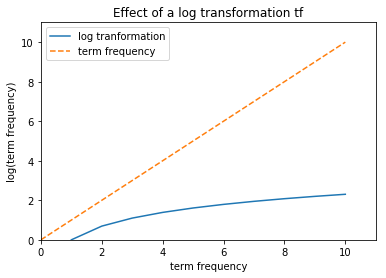

In [92]:
plt.plot(range(11), np.log(range(11)), label='log tranformation')
plt.plot(range(11), range(11), linestyle='--', label='term frequency')
plt.ylabel("log(term frequency)")
plt.ylim(ymax=11, ymin=0)
plt.xlabel("term frequency")
plt.xlim(xmax=11, xmin=0)
plt.title('Effect of a log transformation tf')
plt.legend(loc='top left')
plt.plot()

### Effect of idf

The effect of idf is a low value for a common word that appears in many documents of the corpus, but a high value for a rare word that appears in only a few document. 

In [93]:
# Sentences the Cat article extracted from wikipedia https://en.wikipedia.org/wiki/Cat
cat1 = 'The domestic cat is a small, typically furry, carnivorous mammal.'
cat2 = 'Since cats were venerated in ancient Egypt, they were commonly believed to have been domesticated there.'
cat3 = 'As of a 2007 study, cats are the second most popular pet in the US by number of pets owned, behind freshwater fish'
cat4 = 'In a 2010 study they were ranked the third most popular pet in the UK, after fish and dogs, with around 8 million being owned'

_cat_ appears in all 4 documents, $df_w$ is 4, giving $idf = \log_2 \frac{4}{4}=0$. 

On the other hand _fish_ appears in only 2 documents, $df_w$ is 2, giving $idf = \log_2 \frac{4}{2}=1$. 

When multiplied with a tf with no transformation, the value for _cat_ in each document becomes 0, while the value for _fish_ remains as its frequency count in each document. Idf effectively create a corpus specific stopword.


## Enhancing texts

It's the addition of more information into text:

* Ngram
* Part of speech (POS) tagging
* Entity Recognition

### Ngram

During tokenization, words are treated as stand alone. However, the same sequence of words that appear in different documents in the corpus might be an indication of common topics. Ngram is an attempt to group words in sequence, for example "global trends", "National Supercomputing Centre", "high performance computing".

* Bigram - grouping 2 words together.
* Trigram - grouping 3 words together.
* Quadgram - grouping 4 words together.

Each of the ngrams discovered can be used like a single word token in a DTM.

In [94]:
# performing ngrams.
SCF = 'Supercomputing Frontiers 2017 will explore global trends and innovations in high performance computing.'
SCF_tokens = [w.lower() for w in nltk.word_tokenize(SCF)]
grams = ['bi', 'tri', 'quad']
n_gram_list = []
for i, gram in enumerate(grams, 2):
    print gram + '-gram'
    n_grams = ngrams(SCF_tokens, i) # creating the ngrams. "i" indicates the n value.
    n_grams_clean = [words for words in n_grams 
                     if len((set(words) & set(string.punctuation)) # none of the words are punctuations
                            | (set([w for w in words]) & set(stop_words)))==0] # none of the words are stopwords
    print n_grams_clean, '\n'
    n_gram_list.append(n_grams_clean)
    

bi-gram
[('supercomputing', 'frontiers'), ('frontiers', '2017'), ('explore', 'global'), ('global', 'trends'), ('high', 'performance'), ('performance', 'computing')] 

tri-gram
[('supercomputing', 'frontiers', '2017'), ('explore', 'global', 'trends'), ('high', 'performance', 'computing')] 

quad-gram
[] 



### Part of speech (POS) tagging

POS is the addition of part of speech information of each word.

In [95]:
print SCF, '\n'
print nltk.pos_tag(nltk.word_tokenize(SCF))

Supercomputing Frontiers 2017 will explore global trends and innovations in high performance computing. 

[('Supercomputing', 'VBG'), ('Frontiers', 'NNS'), ('2017', 'CD'), ('will', 'MD'), ('explore', 'VB'), ('global', 'JJ'), ('trends', 'NNS'), ('and', 'CC'), ('innovations', 'NNS'), ('in', 'IN'), ('high', 'JJ'), ('performance', 'NN'), ('computing', 'NN'), ('.', '.')]


<img src='img\POS Tagset.PNG' height='630' width='630' align='left'/>

POS tagging work by looking up into a word lexicon like the famous [wordnet](http://wordnet.princeton.edu/). The part of speech tagging in the lexicon is often tagged by a linguist. In other POS algorithms, the POS returned may also be result of running a machine learning model, previously trained on the POS of known sentences.

As the rules of English or any other languages can be very complicated, it is not a surprise that the POS tagging is not 100% accurate. In fact, humans are not 100% accruate as well. Take for an example the words "bank" and "depend" in the 2 documents below.

In [96]:
print "Can I bank on you to go to the bank by the river bank?"
print nltk.pos_tag(nltk.word_tokenize("Can I bank on you to go to the bank by the river bank?")),'\n'

print "Can I depend on you to go to the bank by the river bank?"
print nltk.pos_tag(nltk.word_tokenize("Can I depend on you to go to the bank by the river bank?"))

Can I bank on you to go to the bank by the river bank?
[('Can', 'MD'), ('I', 'PRP'), ('bank', 'NN'), ('on', 'IN'), ('you', 'PRP'), ('to', 'TO'), ('go', 'VB'), ('to', 'TO'), ('the', 'DT'), ('bank', 'NN'), ('by', 'IN'), ('the', 'DT'), ('river', 'NN'), ('bank', 'NN'), ('?', '.')] 

Can I depend on you to go to the bank by the river bank?
[('Can', 'MD'), ('I', 'PRP'), ('depend', 'VB'), ('on', 'IN'), ('you', 'PRP'), ('to', 'TO'), ('go', 'VB'), ('to', 'TO'), ('the', 'DT'), ('bank', 'NN'), ('by', 'IN'), ('the', 'DT'), ('river', 'NN'), ('bank', 'NN'), ('?', '.')]


"depend" and the first "bank" should obviously be the same POS, but "bank" was intepreted as a noun in the 2nd document instead of a verb.

<img src='img\POS Tagset.PNG' height='630' width='630' align='left'/>

### Entity Recognition

In the nltk library, the entities the can be recognized are:

* People
* Organizations
* Geopolitical entity (GPE)

Prior to recognizing entities, POS tagging has to be performed on the text first.

In [97]:
SCF2 = "Supercomputing Frontiers 2017 is Singapore's annual international conference that provides a platform for thought leaders from both academia and industry to interact and discuss visionary ideas, important global trends and substantial innovations in supercomputing."
print SCF2

SCF2_tokens = nltk.word_tokenize(SCF2)
SCF2_pos = nltk.pos_tag(SCF2_tokens)
SCF2_entity = nltk.ne_chunk(SCF2_pos)

print SCF2_entity

Supercomputing Frontiers 2017 is Singapore's annual international conference that provides a platform for thought leaders from both academia and industry to interact and discuss visionary ideas, important global trends and substantial innovations in supercomputing.
(S
  Supercomputing/VBG
  Frontiers/NNS
  2017/CD
  is/VBZ
  (GPE Singapore/NNP)
  's/POS
  annual/JJ
  international/JJ
  conference/NN
  that/WDT
  provides/VBZ
  a/DT
  platform/NN
  for/IN
  thought/JJ
  leaders/NNS
  from/IN
  both/DT
  academia/NN
  and/CC
  industry/NN
  to/TO
  interact/VB
  and/CC
  discuss/VB
  visionary/JJ
  ideas/NNS
  ,/,
  important/JJ
  global/JJ
  trends/NNS
  and/CC
  substantial/JJ
  innovations/NNS
  in/IN
  supercomputing/NN
  ./.)


But entity recognition only works on capitalized words.

In [98]:
SCF2_2_tokens = [w.lower() for w in nltk.word_tokenize(SCF2)] # lowercase all the tokens.
SCF2_2_pos = nltk.pos_tag(SCF2_2_tokens) #POS taggin remains the same
SCF2_2_entity = nltk.ne_chunk(SCF2_2_pos)
print SCF2_2_entity

(S
  supercomputing/VBG
  frontiers/NNS
  2017/CD
  is/VBZ
  singapore/RBR
  's/POS
  annual/JJ
  international/JJ
  conference/NN
  that/WDT
  provides/VBZ
  a/DT
  platform/NN
  for/IN
  thought/JJ
  leaders/NNS
  from/IN
  both/DT
  academia/NN
  and/CC
  industry/NN
  to/TO
  interact/VB
  and/CC
  discuss/VB
  visionary/JJ
  ideas/NNS
  ,/,
  important/JJ
  global/JJ
  trends/NNS
  and/CC
  substantial/JJ
  innovations/NNS
  in/IN
  supercomputing/NN
  ./.)


In [99]:
SCF3 = 'Supercomputing_Frontiers_2017 will explore global_trends and innovations in high_performance_computing.'

SCF3_tokens = nltk.word_tokenize(SCF3)
SCF3_pos = nltk.pos_tag(SCF3_tokens)
SCF3_entity = nltk.ne_chunk(SCF3_pos)

print SCF3_entity

(S
  (GPE Supercomputing_Frontiers_2017/NNP)
  will/MD
  explore/VB
  global_trends/NNS
  and/CC
  innovations/NNS
  in/IN
  high_performance_computing/NN
  ./.)


## Performing analysis

Here is a non-exhaustive list of analysis that can be performed on text:

* Sentiment analysis
* Document similarity
* Topic modelling
* Topic classification (not covered)
* Document summarization (not covered)

In [100]:
# Setting up the yelp dataset for the demonstration
myDir = 'data/yelp'
f = os.path.join(myDir,'reviews_with_single_category.csv')
data = pd.read_csv(f, encoding="utf-8")

# show the business categories I have filtered to, and the number of reviews per business.
cat_grp = data.groupby('categories')
cat = "Public Services & Government"
data = cat_grp.get_group(cat).reset_index(drop=True)
num_reviews = data.shape[0]
display(data)

,categories,text,stars
0,Public Services & Government,"Festivals. Fun. Beer. Lots of beer. Charlotte Center City Partners (or Find Your Center) puts on a lot of these types of festivals Uptown and in South End. When you check out their website or their weekly newsletter you'll be able to see lots of events coming up like Beer, Blues and BBQ, Taste of Charlotte, Speedstreet and the like. \r\n\r\nMany of these events and festivals usually have beer available, hence why I'm a fan. And, yeah, I also really like supporting the local organization that's responsible for Uptown's development. If only there was a PBR festival...!",4
1,Public Services & Government,"For fun in Center City, Charlotte Center City Partners has it covered!\r\n\r\nYes, these are the folks largely responsible for the big ole event Uptown. Whether it's Beer, Blues & BBQ, Taste of Charlotte, Speedstreet or pumpkin carving for Halloween - I give these guys credit. Considering only 10-12K people live in Uptown, they have a large feat of bringing the masses into Center City. \r\n\r\nAs a whole, these events are well organized, nicely promoted and generally a really good time. Stephen puts it well - every event won't be for everybody, but I appreciate that they try to bring Charlotte together (as we're a large group of transplants). In addition to the events, they also send out a really great calendar of what's going on in Uptown & South End every week. If you don't get it already, definitely check it out.",4
2,Public Services & Government,"Way to ruin driving to downtown, do you know how hard it is to navigate those barricades after a long night at Seamus Mccaffrey's or \r\nGeorge & Dragon!? Go home, YOU SUCK.",1
3,Public Services & Government,"I have taken a ride on the light rail a few times now and I have some stories!! The first time I rode the light rail I took it from Mill Ave to Phoenix to see the D-Backs and Cubs play. My friends had caught a tram in Mesa so I sat there and watched a few trams come and go before I got onto the one with my friends on it. That was easy enough...there was enough room for me and the ride was smooth and fun (though I can't say it was relaxing)...Any ways. After the game was quite an experience! The tram ride home was a little more crowed now that the game had let out. There were two die hard fans in our car from the two teams who started talking trash to each other...well one of them had a little too much to drink and one thing lead to another and they were soon yelling threats at each other. Right before the drunker one took a swing (in a very crowded car) an older man stood up and shut them both up before someone got hurt...the tension in the air was thick the whole way back to Tempe where the Cub fan got off and punched the window. The friends of the other guy had to hold him back...I mean come on!! \r\n\r\nOkay, then I had the pleasure of using the light rail to go to the Circus. Again I was headed to Phoenix but this time I got on at the Washington stop. It was again a fun ride, but I couldn't say that it was a relaxing ride...there was this bum who was asking people for money and I think it would be better with some music playing in the background...any ways the ride home wasn't as eventful as the baseball game crowd, but again, there was another bum asking for money...can people just ride in peace?\r\n\r\nI like the light rail - I really do...it's always an interesting experience, but I just don't feel safe on it. I used to take the metro bus from Gilbert to Mesa every day for a while and I felt safer on that then I do on the light rail and the bums who ride the bus don't ask me for money either.",2
4,Public Services & Government,"I want to like the Light Rail, I really do, I even voted for it. Having moved to Phoenix from a city with a great public transportation system(Chicago) and having visited other large cities with great Public transportation systems, I wanted this for Phoenix too. I wanted to live is a city where 

### Dataset for Demonstration

<img src='img\Yelp_Logo.svg.png' height='128' width='128' align='right'/>To demonstrate the analysis, I have used the text reviews from the Round 8 of the Yelp Challenge. src: https://www.yelp.com/dataset_challenge. 

We will be analyzing the reviews in the **Public Services & government** category, consisting of {{num_reviews}} reviews. Each review has a star rating numbered from 1 to 5.

A preview of the data:

{{display(data.head())}}

### Sentiment analysis

nltk provides a sentiment analysis package called _vader.SentimentIntensityAnalyzer()_. _Vader_, an abbreviation for **Valence Aware Dictionary and sEntiment Reasoner**, is a lexicon (relies on Wordnet) and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. For each document provided as input to Vader, the algorithm calculates the overall sentiment score to between -1 and 1 and calls this score the compound score. A score of -1 is negative, and a score of 1 is positive.

**Vader Rule Overview** 

1. Punctuation, namely the exclamation point (!), increases the magnitude of the intensity without modifying the semantic orientation. For example, “The food here is good!!!” is more intense than “The food here is good.” 
2. Capitalization, specifically using ALL-CAPS to emphasize a sentiment-relevant word in the presence of other non-capitalized words, increases the magnitude of the sentiment intensity without affecting the semantic orientation. For example, “The food here is GREAT!” conveys more intensity than “The food here is great!” 
3. Degree modifiers (also called intensifiers, booster words, or degree adverbs) impact sentiment intensity by either increasing or decreasing the intensity. For example, “The service here is extremely good” is more intense than “The service here is good”, whereas “The service here is marginally good” reduces the intensity. 

<p>4. The contrastive conjunction “but” signals a shift in sentiment polarity, with the sentiment of the text following the conjunction being dominant. “The food here is great, but the service is horrible” has mixed sentiment, with the latter half dictating the overall rating. </p>
<p>5. By examining the tri-gram preceding a sentiment-laden lexical feature, we catch nearly 90% of cases where negation flips the polarity of the text. A negated sentence would be “The food here isn’t really all that great”.</p>

Hutto, C.J., Gilbert, E. June 2014. _VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text._ Eighth International Conference on Weblogs and Social Media (ICWSM-14).

In [101]:
# Assigning a variable to the sentiment analyzer.
midi_chlorian = vader.SentimentIntensityAnalyzer()

# Take the first review as an example.
review1 = data['text'][0]

# Analyze the polarity of this review.
polarity1 = midi_chlorian.polarity_scores(review1)

# the result.
print polarity1, '\n'
print "The star rating given by the reviewer is", data['stars'][0]

{'neg': 0.0, 'neu': 0.742, 'pos': 0.258, 'compound': 0.9766} 

The star rating given by the reviewer is 4


In [102]:
if polarity1['compound'] > 0.25:
    polarity_returned = 'positive'
elif polarity1['compound'] < 0.25:
    polarity_returned = 'negative'
else:
    polarity_returned = 'neutral'

if (polarity_returned == 'positive' and data['stars'][0] > 3) or (polarity_returned == 'negative' and data['stars'][0] < 3) or (polarity_returned == 'neutral' and data['stars'][0] == 3):
    align = 'aligned'
else:
    align = 'not aligned'

The compound score returned is {{polarity1['compound']}}, indicating it is {{polarity_returned}}. The result is {{align}} with the rating of {{data['stars'][0]}} stars given.

How does Vader's compound score relate to the star rating?

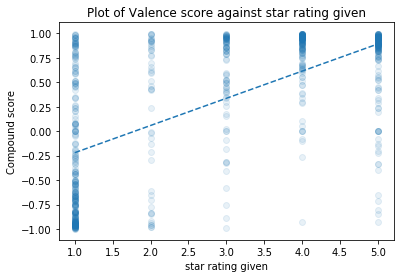

In [269]:
# apply Vader to the whole dataset
data['valence'] = data['text'].apply(midi_chlorian.polarity_scores).apply(lambda x: x['compound'])
# the first apply, applies Vader to each of the text. 
# The second apply extracts the overall polarity score given by the 'compound' key in the dict returned by Vader

# plot the compound score against the star rating.
plt.scatter(data['stars'], data['valence'], alpha=0.1)
# fitting a best fit line thru the points
plt.plot(np.arange(1,6), np.poly1d(np.polyfit(data['stars'], data['valence'], 1))(np.arange(1,6)), linestyle='--')
plt.xlabel('star rating given')
plt.ylabel('Compound score')
plt.title('Plot of Valence score against star rating given')
plt.show()

From the best fit line in the previous plot, we see that the valence score returned by Vader is generally in line with the ratings given by the reviews. The sentiment analyzer is not perfect, as we saw that there are negative valence score givens to reviews awarded 5 stars, and positive valence score given to the reviews awarded 1 star. A closer examination will be required to understand what are the reviews that Vader got wrong.

How good is Vader in identifying 1 star ratings?

In [104]:
# Take a look at the accuracy of sentiment analysis.
def correctness(polarity, stars):
    if (polarity > 0 and stars > 3) or (polarity <= 0 and stars <= 3):
        return True
    else:
        return False

# Here, I am assuming that a 3 star review should have a negative valence.
data['correct_flag'] = ((data['stars']-3.1)*data['valence']) > 0 

accuracy = sum(data.correct_flag)*1./data.shape[0]
print "Accuracy of Vader is: %.2f %%" %(accuracy*100.)

acc_1_star = sum(data[data.stars==1].correct_flag)*1./data[data.stars==1].shape[0]
print "Accuracy on 1 star reviews is: %.2f %%" %(acc_1_star*100.)

Accuracy of Vader is: 69.37 %
Accuracy on 1 star reviews is: 67.73 %


With sentiment analysis, a business can retrieve texts from other data sources which does not contain any star rating information, and grade the sentiment of that text. They can filter the results to texts with negative sentiments. These texts will likely be talking about the negative aspect of the business. This will help the business focus their efforts on these negative aspects.

### Document similarity

Previously, we saw that a business can sieve out text with negative sentiments. While reading through newly collected reviews with negative sentiments, the business realized some topics in the reviews were constantly being mentioned. Management wants to know whether they have received similar feedback in the past. You can find similar reviews by measuring the document similarity for the new reviews with the reviews stored in the database.

Documents can be measured for similarity by comparing the words that appear in the documents. 2 documents with many common words will have high similarity. A similarity score commonly used in text analytics is the **cosine** similarity.

## $\cos similarity = \frac{v.w}{\|v\|\|w\|}$

### $v.w = v_1 * w_1 + v_2 * w_2 + ... + v_N * w_N$

### $\|v\| = \sqrt{v_1^2 + v_2^2 + ... + v_N^2}$

### $\|w\| = \sqrt{w_1^2 + w_2^2 + ... + w_N^2}$

Document v = (1, 1, 1, $\cdots$, 0) --> $\begin{pmatrix}v_1\\v_2\\v_3\\\vdots\\v_n\end{pmatrix}$ --> $\begin{pmatrix}1\\1\\1\\\vdots\\0\end{pmatrix}$


Document w = (0, 0, 1, $\cdots$, 0) --> $\begin{pmatrix}w_1\\w_2\\w_3\\\vdots\\w_n\end{pmatrix}$ --> $\begin{pmatrix}0\\0\\1\\\vdots\\0\end{pmatrix}$

Invert each document in the matrix, and you'll get the vector of a document.

Unlike sentiment analysis, we have to transform the text data into a strutured format before calculating the cosine similarity between document. 

In [217]:
# Performing the preprocessing steps and the structuring steps:
yelp_corpus_tokenize = data.text.apply(nltk.word_tokenize) # tokenize the reviews. Assume there are no emoticons.
yelp_corpus_stopwords = [[w for w in doc if w.lower() not in list(string.punctuation)+stop_words]
                        for doc in yelp_corpus_tokenize]# remove stop words and punctuations
yelp_corpus_regex = [[w for w in doc if re.search('^[a-zA-Z0-9]+$', w)] for doc in yelp_corpus_stopwords]
yelp_corpus_lemma = [[lemma(w) for w in doc] for doc in yelp_corpus_regex] # lowercase and lemmatize

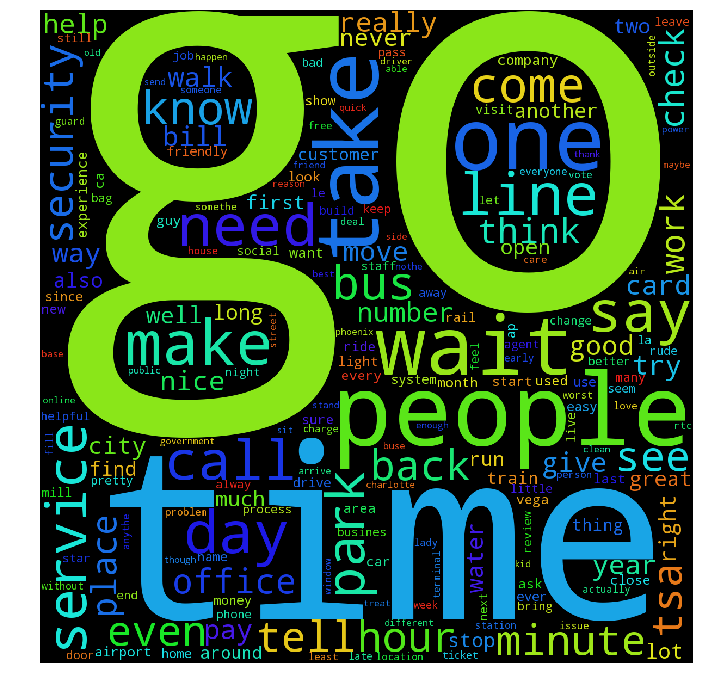

In [218]:
# After preprocessing, inspect the tokens using a wordcloud
wc = WordCloud(background_color='black', stopwords=None, width = 1200, height = 1200)

wc.generate(" ".join([w for doc in yelp_corpus_lemma for w in doc]))
fig = plt.figure()
fig.set_figwidth(12); fig.set_figheight(12); plt.axis('off')
plt.imshow(wc); plt.show()

In [219]:
# Creating a dictionary
yelp_dictionary = corpora.Dictionary(yelp_corpus_lemma)
token_2_id = yelp_dictionary.token2id

# Expressing in a sparse matrix
sparse_mat = [yelp_dictionary.doc2bow(doc) for doc in yelp_corpus_lemma]

# Tf-idf weighting
tfidf = models.TfidfModel(sparse_mat) # learn the tfidf weighting
tfidf_sparse = [tfidf[doc] for doc in sparse_mat] # apply the tfidf weighting

# Create a similarity matrix for all the reviews except the last review.
tfidf_index = similarities.SparseMatrixSimilarity(tfidf_sparse[:-1], len(yelp_dictionary.keys()))

In the above code, we let all the reviews, excluding the last review, be those already present in the company's database, and let the last review be the new review the company received. The *tfidf_index* is created, such that when a new review is received, that new review can be transformed into a sparse vector and passed into tfidf_index to find similar reviews in the database.

In the above text structing process, we applied the tf-idf transformation. This to reduce the influence of common words on the similarity.

In [268]:
sim_to_last_review = tfidf_index[tfidf_sparse[-1]] # find reviews similar to the last review
# sort the similarity score from largest to smallest
sim_to_last_review = sorted(enumerate(sim_to_last_review), key=lambda item: -item[-1])

# The result looks like this (showing the 10 highest similarity):
pd.DataFrame.from_records(sim_to_last_review[:10], columns=['Document index', 'Cosine Similarity'])

,Document index,Cosine Similarity
0,149,0.144934
1,555,0.113416
2,397,0.105878
3,170,0.096139
4,472,0.093123
5,98,0.093010
6,479,0.091975
7,657,0.091330
8,16,0.090466
9,282,0.090093


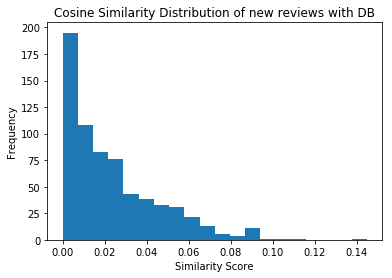

In [221]:
plt.hist(x=map(lambda sim: sim[1], sim_to_last_review), bins=20)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Cosine Similarity Distribution of new reviews with DB')
plt.show()

Examining the "new" review with the most similar review  in the DB.

In [270]:
index_most_similar = sim_to_last_review[0][0]
print 'The "new" review:\n', data.text.iloc[-1], "\n"
print "The most similar review:\n", data.text.iloc[index_most_similar]

The "new" review:
This place is gross. I was there so long was forced to use restroom, yuck. Security grills you up front. I did give 2 stars because at least after 2 hours the lady that helped me was pleasant enough. Glad I don't need to come often lol 

The most similar review:
Never ride this horrible thing there r psycho homeless people everywhere and the bus drivers are seriously extremely retarded I dont know how they still have a job and they steal your money if you make 1 little mistake I payed $5 to get 2 24 hour passes they are $2 each with a student id and the dumbass gives me 2 2 hour passes that isn't even worth $5 so I asked if I could have my dollar back and the retard couldn't understand me so I just got off this bus deserves 0 out of 5 it is just a waste of money to sit next to gross homeless freaks


### Topic modelling

Topic modelling is the text analytics equivalent of clustering. Each cluster, is a cluster of words, and can be thought of as a topic. A difference is, a document may belong to different clusters instead of just 1. That is to say, a document can be categorized into more than 1 topic.

Topic Modelling Algorithms:

1. **Latent Dirichlet allocation (LDA)**
* Latent Semantic Analysis (LSA)

**Latent Dirichlet allocation (LDA)**

Wikipedia Definition: a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.

We initialize the topic model by assuming there are X number of topics in the corpus, where each topic is characterized by the words it contains. The processing steps are the same as in the document simlarity demonstration. With the same reasoning as 

In [223]:
# Let the number of topics be 20
num_topics = 10
PSG_lda = gensim.models.ldamodel.LdaModel(corpus = tfidf_sparse, id2word = yelp_dictionary, num_topics=num_topics)
# Inspect all 10 topics, and show 10 words per topic
pd.DataFrame.from_records(PSG_lda.show_topics(num_topics, 10), columns=['topic index', 'words'])

,topic index,words
0,0,"0.002*""wait"" + 0.002*""staff"" + 0.002*""like"" + 0.001*""office"" + 0.001*""friendly"" + 0.001*""nice"" + 0.001*""helpful"" + 0.001*""work"" + 0.001*""eh"" + 0.001*""good"""
1,1,"0.002*""service"" + 0.002*""bus"" + 0.002*""company"" + 0.002*""bill"" + 0.002*""ap"" + 0.002*""terminal"" + 0.002*""customer"" + 0.002*""pay"" + 0.002*""take"" + 0.002*""need"""
2,2,"0.003*""tsa"" + 0.002*""airport"" + 0.002*""pre"" + 0.002*""line"" + 0.002*""check"" + 0.002*""time"" + 0.002*""fly"" + 0.002*""much"" + 0.002*""never"" + 0.002*""go"""
3,3,"0.002*""go"" + 0.002*""take"" + 0.002*""people"" + 0.002*""get"" + 0.002*""ride"" + 0.002*""love"" + 0.002*""need"" + 0.001*""license"" + 0.001*""state"" + 0.001*""appreciate"""
4,4,"0.002*""tsa"" + 0.002*""go"" + 0.002*""wait"" + 0.002*""location"" + 0.002*""office"" + 0.001*""line"" + 0.001*""security"" + 0.001*""get"" + 0.001*""card"" + 0.001*""u"""
5,5,"0.002*""water"" + 0.002*""time"" + 0.002*""call"" + 0.002*""card"" + 0.001*""de"" + 0.001*""door"" + 0.001*""get"" + 0.001*""say"" + 0.001*""people"" + 0.001*""go"""
6,6,"0.003*""park"" + 0.002*""come"" + 0.002*""day"" + 0.002*""get"" + 0.002*""water"" + 0.002*""bus"" + 0.002*""take"" + 0.002*""number"" + 0.002*""time"" + 0.001*""go"""
7,7,"0.002*""hour"" + 0.002*""line"" + 0.002*""take"" + 0.002*""helpful"" + 0.002*""people"" + 0.002*""wait"" + 0.002*""like"" + 0.002*""get"" + 0.002*""office"" + 0.002*""friendly"""
8,8,"0.002*""tsa"" + 0.002*""airport"" + 0.002*""park"" + 0.002*""wait"" + 0.002*""line"" + 0.002*""go"" + 0.002*""get"" + 0.002*""even"" + 0.001*""agent"" + 0.001*""around"""
9,9,"0.002*""bus"" + 0.001*""security"" + 0.001*""rtc"" + 0.001*""get"" + 0.001*""ap"" + 0.001*""one"" + 0.001*""time"" + 0.001*""say"" + 0.001*""people"" + 0.001*""go"""


Using a visualization, it is perhaps easier to see what the topic is about.

In [224]:
# Credit http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb
pyLDAvis.gensim.prepare(PSG_lda, tfidf_sparse, yelp_dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      15.260653  1        1      -0.025663 -0.021131
1      12.163047  1        2      -0.009970 -0.010553
2      11.971525  1        3      -0.024737  0.023335
3      11.192089  1        4      -0.005801  0.004761
7      11.060279  1        5       0.012749 -0.013599
8      9.242364   1        6       0.005622  0.024445
5      8.714455   1        7       0.008744 -0.010114
4      7.946618   1        8       0.007959 -0.003815
9      6.469862   1        9       0.011113  0.002394
0      5.979108   1        10      0.019984  0.004279, topic_info=     Category      Freq         Term     Total  loglift  logprob
term                                                            
1502  Default  5.000000  tsa          5.000000  30.0000  30.0000
4627  Default  1.000000  pre          1.000000  29.0000  29.0000
1501  Default  1.000000  de           1.000000  28.0000  28.0000
2589  Default  1.000000  library      1.000000  27.0000  27.0000
3755  Default  3.000000  helpful      3.000000  26.0000  26.0000
3084  Default  1.000000  fly          1.000000  25.0000  25.0000
3434  Default  3.000000  airport      3.000000  24.0000  24.0000
2897  Default  1.000000  ir           1.000000  23.0000  23.0000
456   Default  2.000000  vote         2.000000  22.0000  22.0000
41    Default  1.000000  passport     1.000000  21.0000  21.0000
1783  Default  0.000000  eh           0.000000  20.0000  20.0000
636   Default  2.000000  ap           2.000000  19.0000  19.0000
3653  Default  1.000000  fun          1.000000  18.0000  18.0000
788   Default  1.000000  checkpoint   1.000000  17.0000  17.0000
1417  Default  1.000000  appreciate   1.000000  16.0000  16.0000
2258  Default  0.000000  sprinter     0.000000  15.0000  15.0000
1709  Default  2.000000  terminal     2.000000  14.0000  14.0000
1715  Default  0.000000  entrance     0.000000  13.0000  13.0000
2092  Default  1.000000  ye           1.000000  12.0000  12.0000
4551  Default  0.000000  liquid       0.000000  11.0000  11.0000
5026  Default  1.000000  rtc          1.000000  10.0000  10.0000
1078  Default  1.000000  counter      1.000000  9.0000   9.0000 
1863  Default  0.000000  title        0.000000  8.0000   8.0000 
357   Default  1.000000  jury         1.000000  7.0000   7.0000 
4451  Default  1.000000  sometime     1.000000  6.0000   6.0000 
1370  Default  1.000000  daughter     1.000000  5.0000   5.0000 
534   Default  1.000000  s            1.000000  4.0000   4.0000 
920   Default  2.000000  location     2.000000  3.0000   3.0000 
3095  Default  2.000000  agent        2.000000  2.0000   2.0000 
4502  Default  4.000000  water        4.000000  1.0000   1.0000 
...       ...       ...    ...             ...     ...      ... 
5456  Topic10  0.191649  leak         0.997173  1.1676  -7.1061 
2589  Topic10  0.204257  library      1.134057  1.1027  -7.0424 
666   Topic10  0.205096  appointment  1.218184  1.0353  -7.0383 
3861  Topic10  0.167523  dad          0.804578  1.2477  -7.2407 
3755  Topic10  0.315783  helpful      3.026741  0.5567  -6.6067 
4029  Topic10  0.373300  like         4.391373  0.3519  -6.4394 
2341  Topic10  0.338613  friendly     3.595564  0.4543  -6.5369 
3056  Topic10  0.393250  wait         5.324209  0.2113  -6.3873 
5172  Topic10  0.322403  nice         3.479513  0.4381  -6.5860 
4113  Topic10  0.233914  hate         1.702062  0.8323  -6.9068 
1425  Topic10  0.349534  office       4.519583  0.2573  -6.5052 
4236  Topic10  0.283421  rail         2.734372  0.5502  -6.7148 
3376  Topic10  0.213710  file         1.384914  0.9481  -6.9972 
1391  Topic10  0.313224  work         3.681261  0.3528  -6.6149 
3493  Topic10  0.288652  good         3.279573  0.3867  -6.6966 
3796  Topic10  0.239575  30           2.041939  0.6741  -6.8829 
1800  Topic10  0.244719  care         2.273021  0.5881  -6.8617 
3170  Topic10  0.280677  long         3.544742  0.2809  -6.

In [231]:
# This is a pre-built LDA
with open('Demo_PSG_lda.pk','rb') as f:
    saved_lda = pickle.load(f)

pyLDAvis.gensim.prepare(saved_lda, tfidf_sparse, yelp_dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      15.310289  1        1      -0.025663 -0.021131
1      12.195059  1        2      -0.009970 -0.010553
2      11.995918  1        3      -0.024737  0.023335
3      11.105934  1        4      -0.005801  0.004761
7      10.994248  1        5       0.012749 -0.013599
8      9.199527   1        6       0.005622  0.024445
5      8.768484   1        7       0.008744 -0.010114
4      7.909818   1        8       0.007959 -0.003815
9      6.520859   1        9       0.011113  0.002394
0      5.999864   1        10      0.019984  0.004279, topic_info=     Category      Freq         Term     Total  loglift  logprob
term                                                            
1502  Default  5.000000  tsa          5.000000  30.0000  30.0000
4627  Default  1.000000  pre          1.000000  29.0000  29.0000
2589  Default  1.000000  library      1.000000  28.0000  28.0000
1501  Default  1.000000  de           1.000000  27.0000  27.0000
3755  Default  3.000000  helpful      3.000000  26.0000  26.0000
3434  Default  3.000000  airport      3.000000  25.0000  25.0000
3084  Default  1.000000  fly          1.000000  24.0000  24.0000
2897  Default  1.000000  ir           1.000000  23.0000  23.0000
456   Default  2.000000  vote         2.000000  22.0000  22.0000
41    Default  1.000000  passport     1.000000  21.0000  21.0000
1783  Default  0.000000  eh           0.000000  20.0000  20.0000
3653  Default  1.000000  fun          1.000000  19.0000  19.0000
636   Default  2.000000  ap           2.000000  18.0000  18.0000
1417  Default  1.000000  appreciate   1.000000  17.0000  17.0000
788   Default  1.000000  checkpoint   1.000000  16.0000  16.0000
2258  Default  0.000000  sprinter     0.000000  15.0000  15.0000
1709  Default  2.000000  terminal     2.000000  14.0000  14.0000
1715  Default  0.000000  entrance     0.000000  13.0000  13.0000
2092  Default  1.000000  ye           1.000000  12.0000  12.0000
4551  Default  0.000000  liquid       0.000000  11.0000  11.0000
1078  Default  1.000000  counter      1.000000  10.0000  10.0000
1863  Default  0.000000  title        0.000000  9.0000   9.0000 
5026  Default  1.000000  rtc          1.000000  8.0000   8.0000 
357   Default  1.000000  jury         1.000000  7.0000   7.0000 
4451  Default  1.000000  sometime     1.000000  6.0000   6.0000 
1370  Default  1.000000  daughter     1.000000  5.0000   5.0000 
920   Default  2.000000  location     2.000000  4.0000   4.0000 
534   Default  1.000000  s            1.000000  3.0000   3.0000 
3095  Default  2.000000  agent        2.000000  2.0000   2.0000 
2632  Default  1.000000  dmv          1.000000  1.0000   1.0000 
...       ...       ...    ...             ...     ...      ... 
5456  Topic10  0.192315  leak         0.999144  1.1657  -7.1061 
2589  Topic10  0.204966  library      1.132363  1.1042  -7.0424 
666   Topic10  0.205808  appointment  1.219710  1.0340  -7.0383 
3861  Topic10  0.168105  dad          0.805829  1.2461  -7.2407 
3755  Topic10  0.316879  helpful      3.024601  0.5574  -6.6067 
4029  Topic10  0.374596  like         4.389840  0.3522  -6.4394 
2341  Topic10  0.339789  friendly     3.592116  0.4553  -6.5369 
3056  Topic10  0.394615  wait         5.321046  0.2119  -6.3873 
5172  Topic10  0.323522  nice         3.477906  0.4385  -6.5860 
4113  Topic10  0.234726  hate         1.701767  0.8324  -6.9068 
1425  Topic10  0.350748  office       4.519195  0.2574  -6.5052 
4236  Topic10  0.284405  rail         2.732938  0.5507  -6.7148 
3376  Topic10  0.214452  file         1.383820  0.9489  -6.9972 
1391  Topic10  0.314311  work         3.681384  0.3528  -6.6149 
3493  Topic10  0.289654  good         3.280280  0.3864  -6.6966 
3796  Topic10  0.240406  30           2.042341  0.6739  -6.8829 
1800  Topic10  0.245569  care         2.274244  0.5876  -6.8617 
3170  Topic10  0.281652  long         3.542753  0.2814  -6.

From *PSG_lda*, we can get the information regarding the probability of a document falling into one of the topics.

In [242]:
# See the probability of the last document in each topic.
topic_probs =  PSG_lda.get_document_topics(tfidf_sparse[-1])
print topic_probs

[(0, 0.018175072158611097), (1, 0.018178502119273014), (2, 0.018179116345868159), (3, 0.018176343000898675), (4, 0.018175970446775436), (5, 0.018175939471774965), (6, 0.83640667763570897), (7, 0.018177606848550985), (8, 0.018179100555805051), (9, 0.018175671416733517)]


In [246]:
most_relevant = sorted(topic_probs, key=lambda x: x[1], reverse=True)

The most relevant topic is topic {{most_relevant[0][0]}} with a proability of {{most_relevant[0][1]}}.

The topic is **{{' + '.join(map(lambda x: x[0], PSG_lda.show_topic(6)))}}**

Inspect the most relevant document in a topic,

In [266]:
topic_num_to_inspect = 6 # define the topic number to inspect

prob_list = []
for doc in tfidf_sparse:
    prob_dict = {}
    probs = PSG_lda.get_document_topics(doc)
    for p in probs:
        prob_dict[p[0]] = p[1]
    prob_list.append(prob_dict)
# Represent the dictionary as a dataframe, with each topic number as the column header, probability value as values in the cell.
# Each row represent a document.
docTerm_prob_df = pd.DataFrame(prob_list) 

most_relevant_index = np.argmax(docTerm_prob_df[topic_num_to_inspect])
print "Relevance score:", np.max(docTerm_prob_df[topic_num_to_inspect])
print data.text.iloc[most_relevant_index] # inspect the most relevant review

Relevance score: 0.923999643399
Review is for the Luke Air Force Base Air Show on April 2-3, 2016

Parking/Getting to the base - located at the corner of Litchfield & Olive in the large open spaced area.  There is another designated parking lot which also serves as handicapped as well but I'm not sure where that one was located.  Be prepared for lots of dust!  
A suggestion would be to leave very early as we left closer to the time the air show started, and it was standstill traffic practically the entire way down to the base via Litchfield, despite police directing traffic which wasn't much help.
Also, do keep note of your parking aisle because that'll be important when returning for your vehicle as the aisles aren't marked.
After parking, be prepared for a security check point - wand, and all pockets emptied, all bags checks - this is only understandable and obvious.
After the security check point, there are school buses available to bring you to the base.

Admission - free.  Food - 

In [271]:
print "Relevance score:", np.max(docTerm_prob_df[topic_num_to_inspect])
print data.text.iloc[most_relevant_index] # inspect the most relevant review

Relevance score: 0.923999643399
Review is for the Luke Air Force Base Air Show on April 2-3, 2016

Parking/Getting to the base - located at the corner of Litchfield & Olive in the large open spaced area.  There is another designated parking lot which also serves as handicapped as well but I'm not sure where that one was located.  Be prepared for lots of dust!  
A suggestion would be to leave very early as we left closer to the time the air show started, and it was standstill traffic practically the entire way down to the base via Litchfield, despite police directing traffic which wasn't much help.
Also, do keep note of your parking aisle because that'll be important when returning for your vehicle as the aisles aren't marked.
After parking, be prepared for a security check point - wand, and all pockets emptied, all bags checks - this is only understandable and obvious.
After the security check point, there are school buses available to bring you to the base.

Admission - free.  Food - 

### Topic Classification

Topic classification is a supervise learning method. It requires that you have pre-labelled data to train a classification model on. Like training a model on structured data, each token in a dictionary is a variable. The model building steps will be exacly the same as that for structured data, just that the number of variables is going to be very large, and some more accurate algorithms will take a long while to be trained.

In a new test data, it may contain tokens that have not be seen before. The way to deal with new tokens is either to omit that data or to provision of a wildcard token in the dictionary.

# Q&A

# Additional

## Why is it important to become tfidf: A contrived example

Say we want to find the similarity between 3 documents.

1. Restaurant Restaurant Restaurant Restaurant Restaurant Restaurant Restaurant avocado chicken delicious.
* Food delicious.
* Restaurant Restaurant Restaurant Restaurant Restaurant Restaurant Restaurant ambient tempature too cold.

In [146]:
doc1 = "Restaurant Restaurant Restaurant Restaurant Restaurant Restaurant Restaurant chicken pie delicious"
doc2 = "Restaurant Food delicious"
doc3 = "Restaurant Restaurant Restaurant Restaurant Restaurant Restaurant Restaurant ambient tempature too cold"

tokens = [d.split() for d in [doc1, doc2, doc3]]
contrive_dict = corpora.Dictionary(tokens)
sparse_vector = [contrive_dict.doc2bow(doc) for doc in tokens]
index = similarities.SparseMatrixSimilarity(sparse_vector, len(contrive_dict.items()))

for i, similarity in enumerate(index[sparse_vector[0]][1:], 1):
    print 'doc1 similarity with doc%i: %f' %(i+1, similarity)

doc1 similarity with doc2: 0.640513
doc1 similarity with doc3: 0.933376


It would seem like doc1 is more similar to doc2 than to doc3. However the cosine similarity of doc3 is higher than doc2, so doc1 is most simlar to doc3. We can see that this is because of the excessive frequency of the term "Restaurant" causing this discrepency. 

If tf-idf is applied:

In [147]:
tfidf_contrieved = models.TfidfModel(sparse_vector)
tfidf_sparse = [tfidf_contrieved[doc] for doc in sparse_vector]
tfidf_index = similarities.SparseMatrixSimilarity(tfidf_sparse, len(contrive_dict.items()))

for i, similarity in enumerate(tfidf_index[tfidf_sparse[0]][1:], 1):
    print 'doc1 similarity with doc%i: %f' %(i+1, similarity)

doc1 similarity with doc2: 0.087431
doc1 similarity with doc3: 0.000000


## Other Applications of Similarity Between Documents

Calculating similarity between documents can help us to group documents. Why do we want to do that?

Applications:
1. Plagarism checker:
    * An essay submitted can be compared for similarity with the other essays in the database.
* An online retailer searching for its products that belong in the same category and groups them together. 
    * Helps visitor to its website find similar items.